In [21]:
import secrets
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.utils.data as data
from tqdm import tqdm
import pandas as pd
import numpy as np

from numpy import recarray
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.utils.data as data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.nn import functional as F
import os

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [22]:
class mHealth(data.Dataset):

    def __init__(self, dataframe, raw_data):
        """
        Args:
            csv_file (string): path to csv file with data
        """
        self.dataset = dataframe
        self.raw_data = raw_data

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index

        Returns:
            (sequence, label)
            returns the time series data then label value for data
        """

        sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
        target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)

        return sequence, target

def collate_fn(batch):
    # Get the maximum length in the batch
    max_length = max(len(x[0]) for x in batch)

    # Pad all sequences to the maximum length
    padded_y_batch = []
    padded_x_batch = []
    for x,y in batch:
        padded_x = torch.cat([x, torch.zeros(max_length - len(x))], dim=0)
        padded_y = torch.cat([y, torch.zeros(max_length - len(y))], dim=0)
        padded_x_batch.append((padded_x))
        padded_y_batch.append((padded_y))


    padded_x_batch = torch.stack(padded_x_batch)
    padded_y_batch = torch.stack(padded_y_batch)

    return padded_x_batch, padded_y_batch

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )

    def forward(self, x):

        x = x.unsqueeze(dim=0)
        x = x.permute(1, 2, 0)
        outputs, (hidden, cell) = self.lstm(x)
        
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=1, hidden_size=64, output_size=1, num_layers=2
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(hidden_size,
                            output_size)

    def forward(self, x, hidden):
        x = x.reshape(512, 1, 64)
        hidden = (hidden[0].unsqueeze(dim=0), hidden[1].unsqueeze(dim=0))
        output, (hidden, cell) = self.lstm(x, hidden)

        prediction = self.fc(output)
        
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, hidden_size, latent_size, device
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size of LSTM AE
        latent_size: int, latent z-layer size
        num_lstm_layer: int, number of layers in LSTM
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 1

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=self.num_layers
        )

        self.lstm_dec = Decoder(
            input_size=64,
            output_size=16,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )

        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        x = x.squeeze()
        # print("x shape: ", x.shape)
        batch_size, seq_len = x.shape
        feature_dim = 1

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
    
        z = z.view(batch_size, seq_len, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()

        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

<>:131: SyntaxWarning: invalid escape sequence '\m'
<>:131: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_30287/3497345825.py:131: SyntaxWarning: invalid escape sequence '\m'
  """


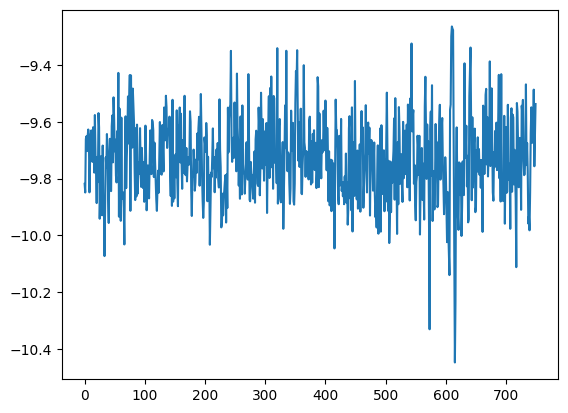

In [24]:
dataset_path = os.getcwd() + '/processed_data/mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)
dataset = dataset['chest acceleration X-axis']
plt.plot(dataset[:750])

In [25]:
dataset = torch.tensor(dataset)
dataset.shape

torch.Size([161280])

In [26]:
LOAD_MODEL = False
split_idx = int(len(dataset) * 0.8)

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
    raw_data=dataset
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
    raw_data=dataset
)

batch_size = 512
input_size = 16
hidden_size = 64
latent_size = 4
num_layers = 2

# if torch.cuda.is_available():
#     device = 'cuda'
#     print("cuda")
# else:
device = 'cpu'
print("cpu")

if(LOAD_MODEL):
    model = LSTMVAE(input_size, hidden_size, latent_size, device=device)
    model.load_state_dict(torch.load('C:\\Users\Admin\\.vscode\PyTorch\\lstm_vae\\model'))
else:
    # define LSTM-based VAE model
    model = LSTMVAE(input_size, hidden_size, latent_size, device=device)

cpu


<>:30: SyntaxWarning: invalid escape sequence '\A'
<>:30: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_30287/3901390549.py:30: SyntaxWarning: invalid escape sequence '\A'
  model.load_state_dict(torch.load('C:\\Users\Admin\\.vscode\PyTorch\\lstm_vae\\model'))


In [37]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")


for idx, data in enumerate(train_loader):
    datas = data[0]
    labels = data[1]
    print("datas shape: ", datas.shape)
    break
    print("Data shape:", datas.shape)
    #print("Labels:", labels)
   # ("Labels shape:", len(labels))
    print("labels shape", labels.shape)
    break

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x7927fc31ff80>
Length of train_dataloader: 252 batches of 512
datas shape:  torch.Size([512, 16])


/tmp/ipykernel_30287/3043097095.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
/tmp/ipykernel_30287/3043097095.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)


In [28]:
train_loss = []
test_loss = []

def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    ## interation setup
    epochs = tqdm(range(iterations // len(train_loader)))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader)-32, desc="training"
        )

        for i, batch_data in train_iterator:

            if count > iterations:
                return model
            count += 1

            past_data, future_data = batch_data

            mloss, recon_x, info = model(past_data)

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
            train_loss.append(float(mloss.mean()))


        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for i, batch_data in test_iterator:
                future_data, past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )

                mloss, recon_x, info = model(past_data)

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"eval_loss": float(mloss.mean())})
                test_loss.append(float(mloss.mean()))

        eval_loss = eval_loss / len(test_loader)
        # writer.add_scalar("eval_loss", float(eval_loss), epoch)
        print("Evaluation Score : [{}]".format(eval_loss))

    return model


In [32]:
iterations = 30000
train(iterations, model, train_loader, train_loader)
# torch.save(model.state_dict(), '/home/jm/vscode/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/model_state_dict')

  0%|          | 0/30000 [00:00<?, ?it/s]/tmp/ipykernel_30287/3043097095.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
/tmp/ipykernel_30287/3043097095.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)
training: 252it [00:09, 27.03it/s, train_loss=0.537]
  0%|          | 1/30000 [00:15<126:47:39, 15.22s/it]

Evaluation Score : [4.58189150265285]


training: 252it [00:09, 25.24it/s, train_loss=0.547]
  0%|          | 2/30000 [00:31<130:23:45, 15.65s/it]

Evaluation Score : [4.641916017683726]


training: 252it [00:09, 25.24it/s, train_loss=0.546]
  0%|          | 3/30000 [00:47<131:39:24, 15.80s/it]

Evaluation Score : [4.616266833411323]


training: 252it [00:09, 25.89it/s, train_loss=0.548]
  0%|          | 4/30000 [01:02<131:03:15, 15.73s/it]

Evaluation Score : [4.70230776166159]


training: 252it [00:09, 25.52it/s, train_loss=0.543]
  0%|          | 5/30000 [01:18<130:44:59, 15.69s/it]

Evaluation Score : [4.717250632861304]


training: 252it [00:09, 25.95it/s, train_loss=0.529]
  0%|          | 6/30000 [01:33<130:08:26, 15.62s/it]

Evaluation Score : [4.73453970939394]


training: 252it [00:09, 26.17it/s, train_loss=0.558]
  0%|          | 7/30000 [01:49<130:01:10, 15.61s/it]

Evaluation Score : [4.770935287551274]


training: 252it [00:09, 26.74it/s, train_loss=0.495]
  0%|          | 8/30000 [02:04<129:06:43, 15.50s/it]

Evaluation Score : [4.783218274040828]


training: 252it [00:09, 27.06it/s, train_loss=0.565]
  0%|          | 9/30000 [02:19<127:32:30, 15.31s/it]

Evaluation Score : [4.740185716795543]


training: 252it [00:09, 27.79it/s, train_loss=0.636]
  0%|          | 10/30000 [02:34<125:59:40, 15.12s/it]

Evaluation Score : [4.737729570222279]


training: 252it [00:09, 26.71it/s, train_loss=0.577]
  0%|          | 11/30000 [02:49<125:59:34, 15.12s/it]

Evaluation Score : [4.652466938609169]


training: 252it [00:09, 27.05it/s, train_loss=0.547]
  0%|          | 12/30000 [03:04<125:36:21, 15.08s/it]

Evaluation Score : [4.635264631301638]


training: 252it [00:09, 27.07it/s, train_loss=0.521]
  0%|          | 13/30000 [03:19<125:32:31, 15.07s/it]

Evaluation Score : [4.662066904325334]


training: 252it [00:09, 27.44it/s, train_loss=0.55]
  0%|          | 14/30000 [03:34<124:40:57, 14.97s/it]

Evaluation Score : [4.710454393946935]


training: 252it [00:09, 27.46it/s, train_loss=0.555]
  0%|          | 15/30000 [03:49<124:25:33, 14.94s/it]

Evaluation Score : [4.71106305198064]


training: 252it [00:09, 27.12it/s, train_loss=0.571]
  0%|          | 16/30000 [04:04<124:37:37, 14.96s/it]

Evaluation Score : [4.703703409149533]


training: 252it [00:09, 27.11it/s, train_loss=0.46]
  0%|          | 17/30000 [04:18<124:24:30, 14.94s/it]

Evaluation Score : [4.772660779574561]


training: 252it [00:09, 27.39it/s, train_loss=0.5]
  0%|          | 18/30000 [04:33<124:00:10, 14.89s/it]

Evaluation Score : [4.747287718076555]


training: 252it [00:09, 27.04it/s, train_loss=0.464]
  0%|          | 19/30000 [04:48<124:10:50, 14.91s/it]

Evaluation Score : [4.752907539170886]


training: 252it [00:09, 27.77it/s, train_loss=0.465]
  0%|          | 20/30000 [05:03<123:28:43, 14.83s/it]

Evaluation Score : [4.751879552054027]


training: 252it [00:09, 26.81it/s, train_loss=0.527]
  0%|          | 21/30000 [05:18<124:08:56, 14.91s/it]

Evaluation Score : [4.83931282966856]


training: 252it [00:09, 26.75it/s, train_loss=0.519]
  0%|          | 22/30000 [05:33<124:45:57, 14.98s/it]

Evaluation Score : [4.781952384918455]


training: 252it [00:09, 26.72it/s, train_loss=0.469]
  0%|          | 23/30000 [05:48<125:11:24, 15.03s/it]

Evaluation Score : [4.780880714219714]


training: 252it [00:09, 26.22it/s, train_loss=0.568]
  0%|          | 24/30000 [06:04<126:02:19, 15.14s/it]

Evaluation Score : [4.797808185456291]


training: 252it [00:09, 26.40it/s, train_loss=0.558]
  0%|          | 25/30000 [06:19<126:17:27, 15.17s/it]

Evaluation Score : [4.774409755827889]


training: 252it [00:09, 27.39it/s, train_loss=0.459]
  0%|          | 26/30000 [06:34<125:34:17, 15.08s/it]

Evaluation Score : [4.865138791856312]


training: 252it [00:09, 26.29it/s, train_loss=0.514]
  0%|          | 27/30000 [06:49<125:56:59, 15.13s/it]

Evaluation Score : [4.846201170058477]


training: 252it [00:09, 26.54it/s, train_loss=0.529]
  0%|          | 28/30000 [07:04<125:52:10, 15.12s/it]

Evaluation Score : [4.824349944553678]


training: 252it [00:09, 27.01it/s, train_loss=0.424]
  0%|          | 29/30000 [07:19<125:18:57, 15.05s/it]

Evaluation Score : [4.716727847144718]


training: 252it [00:09, 27.05it/s, train_loss=0.483]
  0%|          | 30/30000 [07:34<125:23:30, 15.06s/it]

Evaluation Score : [4.747323024840582]


training: 252it [00:09, 26.15it/s, train_loss=0.483]
  0%|          | 31/30000 [07:50<126:28:31, 15.19s/it]

Evaluation Score : [4.72469501268296]


training: 252it [00:09, 26.09it/s, train_loss=0.483]
  0%|          | 32/30000 [08:05<126:49:16, 15.23s/it]

Evaluation Score : [4.764757538598682]


training: 252it [00:09, 26.25it/s, train_loss=0.463]
  0%|          | 33/30000 [08:20<127:01:24, 15.26s/it]

Evaluation Score : [4.778108944968571]


training: 252it [00:09, 26.17it/s, train_loss=0.47]
  0%|          | 34/30000 [08:36<127:47:15, 15.35s/it]

Evaluation Score : [4.7482732269499035]


training: 252it [00:09, 26.15it/s, train_loss=0.403]
  0%|          | 35/30000 [08:51<127:57:59, 15.37s/it]

Evaluation Score : [4.760724389363849]


training: 252it [00:09, 25.76it/s, train_loss=0.583]
  0%|          | 36/30000 [09:07<128:22:56, 15.42s/it]

Evaluation Score : [4.746034482168773]


training: 252it [00:09, 26.37it/s, train_loss=0.437]
  0%|          | 37/30000 [09:22<128:19:21, 15.42s/it]

Evaluation Score : [4.811360275934613]


training: 252it [00:09, 26.23it/s, train_loss=0.446]
  0%|          | 38/30000 [09:38<128:12:48, 15.41s/it]

Evaluation Score : [4.792711668544346]


training: 252it [00:09, 26.51it/s, train_loss=0.436]
  0%|          | 39/30000 [09:53<128:19:12, 15.42s/it]

Evaluation Score : [4.830785702145289]



training: 223it [00:08, 26.43it/s, train_loss=0.485]
  0%|          | 39/30000 [10:01<128:26:49, 15.43s/it]


KeyboardInterrupt: 

In [33]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for i, batch in dataloader:
            # print(batch.shape)
            x = batch  # Assuming batch is a tuple (data, target), adjust if necessary

            ## reshape
            batch_size = x.size(0)
            example_size = x.size(1)
            x = (
                x.view(batch_size, example_size, -1).float().to(device)
            )

            mloss, recon_x, info = model(x)
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

/tmp/ipykernel_30287/3043097095.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
/tmp/ipykernel_30287/3043097095.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)


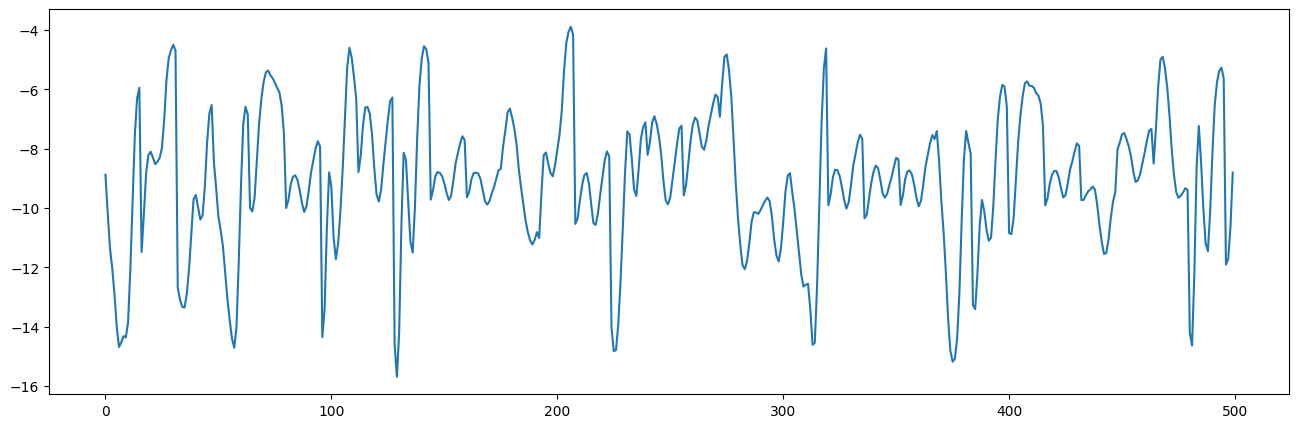

In [34]:
reconstruction = predict(model, test_loader)
reconstruction = reconstruction.reshape(516096, 1)
reconstruction = reconstruction.squeeze()
reconstruction = reconstruction.cpu().numpy()

plt.figure(figsize=(16,5))
plt.plot(reconstruction[:500])
# plt.plot(dataset[:750])
# plt.legend(["Test series ", "Reconstructed test series "])
# plt.ylabel("Acceleration value")
# plt.xlabel("Timestep")

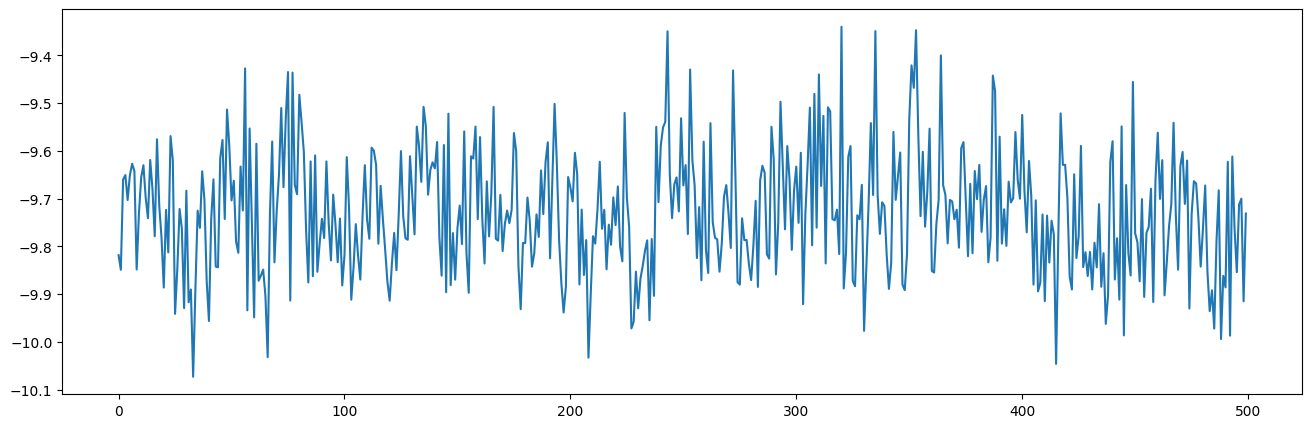

In [35]:
plt.figure(figsize=(16,5))
plt.plot(dataset[:500])

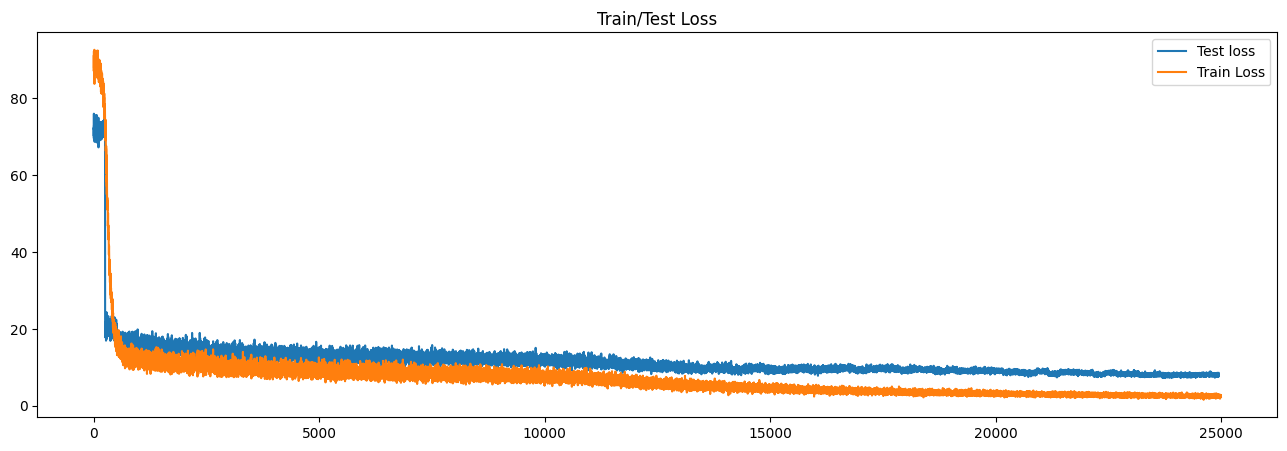

In [ ]:
plt.figure(figsize=(16,5))
plt.title("Train/Test Loss")
plt.plot(test_loss, label='Test loss')
plt.plot(train_loss, label='Train Loss')
plt.legend()